# Practica I: Clasificación Binaria

## Introducción
<div style="text-align: justify; margin-top:1.5em; margin-right:3em">En este primer cuaderno vamos ver el tipo de problema básico con redes neuronales: <b>Clasificación Binaria</b>. Los problemas de clasificación binaria se caracterizan por aprender a clasificar sólo dos tipos de datos. Simplificando bastate este tipo de problemas, nos da una respuesta que puede ser: <i>si</i> o <i>no</i>. Vamos a ver un ejemplo de este problema para ver como funcionan.</div>

## Contexto del problema
<div style="text-align: justify; margin-top:1.5em; margin-right:3em">Una asociación de animales está preparandose para la edición de este año de su concurso de fotografía, en este concurso se pide enviar imágenes de perros y gatos que son las dos catagorias del concurso. Con el tiempo el número de participantes ha ido aumentando y la cantidad de imágenes a clasificar se ha vuelto demasiado grande como para hacerlo manualmente. La asociación nos ha pedido que le ofrezcamos una solución que les permita automatizar la clasificación de las imágenes que envían los participantes.</div>

<div style="text-align: justify; margin-top:1.5em; margin-right:3em">La solución a la que se ha llegado ha sido desarrollar un modelo capaz de clasificar las imágenes y la asociación a proporcionado una gran cantidad de imágenes de las ediciones anteriores para entrenar el modelo.</div>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Path to the images of the dataset
train_path = './images/cats_vs_dogs/train'           # path to training data
validation_path = './images/cats_vs_dogs/validation' # path to validation data
test_path = './images/cats_vs_dogs/test'             # path to test data

<div style="text-align: justify; margin-top:1.5em; margin-right:3em">Primero vamos a cargar los datos que usaremos para entrenar la red. Las imágenes se encuentran compromidas en el archivo <code>images.zip</code>, este archivo debe ser descomprimido para realizar el ejercicio. Debido a que la capacidad de memoria del ordenador es limitada para albergar todos estos archivos a la vez, vamos a utilizar la clase que se encuentra en el paquete <code>tensorflow.keras.preprocessing.image.ImageDataGenerator</code> que permite cargar imagenes de un directorio de manera dinámica durante el proceso de entrenamiento.</div>

<div style="text-align: justify; margin-top:1.5em; margin-right:3em">Esta clase debe usar en su constructor el parámetro <code>rescale</code> para pasar las imágenes de un rango de <code>[0, 255]</code> a un rango <code>[0, 1]</code> ya que este rango es más adecuado para los proccesos de aprendizaje. Una vez generado el objeto de esta clase, utilizaremos la función <code>flow_from_directory()</code> para especificar la ruta donde se encuentran las imágenes. Debemos especificar los siguientes parámetros:</div>

- `path`: ruta a las imágenes.
- `target_size`: dimensiones a las que se debe ajustar la imagen.
- `batch_size`: tamaño del batch.
- `class_mode`: tipo de problema a resolver, en este caso debe ser `class_mode='binary'`.

Esta función devolverá un objeto **Generador** de las imágenes, además imprimirá por pantalla las cantidad de datos y de imágenes que ha encontrado.

In [3]:
# Create the data generator for the input data
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print('Loading training data:')
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    train_path,
    target_size=(150, 150),
    batch_size=40,
    class_mode='binary'
)

print('\nLoading validation data:')
validation_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    validation_path,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

print('\nLoading test data:')
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_path,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

Loading training data:
Found 15994 images belonging to 2 classes.

Loading validation data:
Found 2000 images belonging to 2 classes.

Loading test data:
Found 2000 images belonging to 2 classes.


La salida esperada para la anterior celda de código con el dataset proporcionado debe ser:
<p style="color: blue; font-family: 'Courier New', monospace">
Loading trainning data:<br/>
Found 15994 images belonging to 2 classes.<br/>
</p>
<p style="color: blue; font-family: 'Courier New', monospace">
Loading validation data:<br/>
Found 2000 images belonging to 2 classes.<br/>
</p>
<p style="color: blue; font-family: 'Courier New', monospace">
Loading test data:<br/>
Found 2000 images belonging to 2 classes.<br/>
</p>

In [4]:
# Import classes for the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

<div style="text-align: justify; margin-top:1.5em; margin-right:3em">Ahora que ya hemos cargado los datos necesarios, vamos a generar el modelo que aprenderá a clasificar las imágenes. Aunque antes de empezar vamos a hablar del tipo de neurona fundamental para resolver los problemas de visión por computador. Esta neurona se conoce como <b>Neurona Convolucional</b> y se caracteriza por:</div>

1. Tomar como entrada una secuencia bidimensioal de datos, imágenes generalmente. A diferencia de las neuronas vistas hasta ahora que tomaban como entrada una secuencia unidimensional de datos.
2. Aplicación de la operación de convolución. Estas neuronass realizan la operación de convolución en lugar de la suma ponderada de su comportamiento clásico.
3. <div style="text-align: justify; margin-top:1.5em; margin-right:3em">Se aprende el kernel o máscara en lugar de los pesos. A diferencia de las neuronas normales, estas neuronas tratan de aprender el filtro que deben aplicar a la imagen, en capas inferiores aprenden a detectar elementos básicos de la imagen como líneas, bordes y curvas. A medida que se va subiendo la red, estas neuronas aprenden a detectar elementos más complejos como ojos, manos, formas, ect. Se recomienda utiliar kernels de tamaño <code>(3,3)</code> o <code>(5,5)</code> ya que ofrecen buenos resultados.</div>

<div style="text-align: justify; margin-top:1.5em; margin-right:3em">La estructura que siguen las redes neuronales convolucionales es tomas los datos de entrada en la capa, los resultados de la capa son procesados para reducir su tamaño conforme se asciende en la jerarquía de capas. Al reducir el tamaño de las imágenes se pierde calidad pero a la vez se consigue que la red aprende mejor formas complejas al simplificarlas.</div>

<div style="text-align: justify; margin-top:1.5em; margin-right:3em">Una vez que se ha terminado con el bloque de capas convolucionales, tenemos que adaptar la salida para que tenga una forma unidimensional para poder procesar los resultados en un bloque de neuronas tradicionales. También recordar que la última capa de la red debe tener tantas neuronas como clases a clasificar tengamos.</div>

Debido a que el problema require de una red un tanto compleja para un nivel inical, se recomienda seguir la estructura planteada.

In [5]:
# Build the model
model = Sequential()

# Stack the layers
model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(150, 150, 3))) # Input layer
model.add(MaxPooling2D(2,2)) # Downsize the results
model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.5)) # Ignore some outputs to avoid overfitting
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Flatten()) # Convert to 1D
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid')) # Output layer

# Setup the optimizer
opt = Adam(learning_rate=0.001)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 17, 17, 64)        0

<div style="text-align: justify; margin-top:1.5em; margin-right:3em">El útlimo paso es realizar el proceso de entrenamiento. En este caso el problema tardará bastante tiempo en ejecutarse, por lo que si se desea se puede utilizar el archivo <code>cats_vs_dogs.h5</code> que cuenta con una red ya entrenada. Por otro lado, si se desea entrenar pero cada epoch tarda demasiado (>1m), recomendamos reducir el parámetro <code>steps_per_epoch</code> aunque puede que no se obtengan resultados satisfactorios.</div>

In [6]:
history = model.fit(train_generator, steps_per_epoch=100, epochs=120,
                   validation_data=validation_generator, validation_steps=64)

Epoch 1/120
100/100 [==============================] - 198s 2s/step - loss: 0.6986 - accuracy: 0.4909 - val_loss: 0.6921 - val_accuracy: 0.5266
Epoch 2/120
100/100 [==============================] - 156s 2s/step - loss: 0.6810 - accuracy: 0.5485 - val_loss: 0.6814 - val_accuracy: 0.5625
Epoch 3/120
100/100 [==============================] - 149s 1s/step - loss: 0.6735 - accuracy: 0.5902 - val_loss: 0.6607 - val_accuracy: 0.6195
Epoch 4/120
100/100 [==============================] - 152s 2s/step - loss: 0.6414 - accuracy: 0.6388 - val_loss: 0.6150 - val_accuracy: 0.6812
Epoch 5/120
100/100 [==============================] - 141s 1s/step - loss: 0.6099 - accuracy: 0.6600 - val_loss: 0.6213 - val_accuracy: 0.6562
Epoch 6/120
100/100 [==============================] - 125s 1s/step - loss: 0.5940 - accuracy: 0.6845 - val_loss: 0.6218 - val_accuracy: 0.6531
Epoch 7/120
100/100 [==============================] - 145s 1s/step - loss: 0.5781 - accuracy: 0.6914 - val_loss: 0.5406 - val_accuracy:

100/100 [==============================] - 224s 2s/step - loss: 0.1905 - accuracy: 0.9257 - val_loss: 0.1881 - val_accuracy: 0.9297
Epoch 58/120
100/100 [==============================] - 239s 2s/step - loss: 0.1958 - accuracy: 0.9211 - val_loss: 0.2243 - val_accuracy: 0.9094
Epoch 59/120
100/100 [==============================] - 174s 2s/step - loss: 0.1682 - accuracy: 0.9321 - val_loss: 0.2284 - val_accuracy: 0.9102
Epoch 60/120
100/100 [==============================] - 228s 2s/step - loss: 0.1960 - accuracy: 0.9199 - val_loss: 0.2060 - val_accuracy: 0.9242
Epoch 61/120
100/100 [==============================] - 229s 2s/step - loss: 0.2023 - accuracy: 0.9191 - val_loss: 0.2058 - val_accuracy: 0.9164
Epoch 62/120
100/100 [==============================] - 226s 2s/step - loss: 0.1915 - accuracy: 0.9265 - val_loss: 0.1952 - val_accuracy: 0.9133
Epoch 63/120
100/100 [==============================] - 227s 2s/step - loss: 0.1788 - accuracy: 0.9297 - val_loss: 0.1880 - val_accuracy: 0.927

100/100 [==============================] - 179s 2s/step - loss: 0.0781 - accuracy: 0.9711 - val_loss: 0.1963 - val_accuracy: 0.9266
Epoch 114/120
100/100 [==============================] - 198s 2s/step - loss: 0.1132 - accuracy: 0.9559 - val_loss: 0.2314 - val_accuracy: 0.9148
Epoch 115/120
100/100 [==============================] - 155s 2s/step - loss: 0.1357 - accuracy: 0.9477 - val_loss: 0.3057 - val_accuracy: 0.8680
Epoch 116/120
100/100 [==============================] - 149s 1s/step - loss: 0.1163 - accuracy: 0.9535 - val_loss: 0.1716 - val_accuracy: 0.9352
Epoch 117/120
100/100 [==============================] - 124s 1s/step - loss: 0.1126 - accuracy: 0.9568 - val_loss: 0.1734 - val_accuracy: 0.9375
Epoch 118/120
100/100 [==============================] - 123s 1s/step - loss: 0.1105 - accuracy: 0.9610 - val_loss: 0.1567 - val_accuracy: 0.9430
Epoch 119/120
100/100 [==============================] - 122s 1s/step - loss: 0.1165 - accuracy: 0.9520 - val_loss: 0.1591 - val_accuracy:

La siguiente celda de código muestra los resultados que se han obtenido durante el proceso de entrenamiento, mostrando la evolución de la precisión de la red y los valores de la Función de Coste obtenidos por los datos de entrenamiento y los datos de validación.

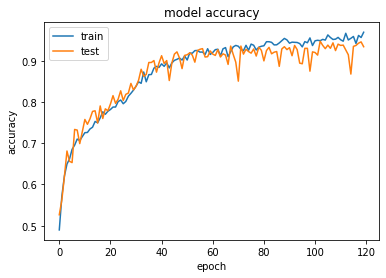

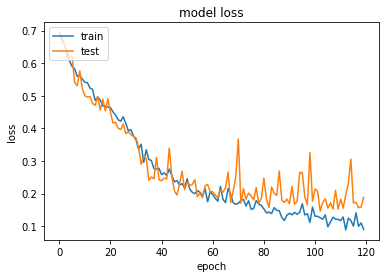

In [7]:
# Plot the training data
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Ahora vamos a utilizar el último conjunto de datos que nos falta, los datos de prueba. Con este conjunto de datos comprobaremos como se comportas el modelo con datos nuevos que no ha visto nunca.

In [ ]:
# Test the model with new data
score = model.evaluate(test_generator, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [13]:
# Save the model
model.save('cats_vs_dogs.h5')